# An Exploration of UW Pharmacy Student Reflections

Author: James Geronimo (jegeronimo@berkeley.edu)

## Libraries and Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

import re

from sklearn.feature_extraction.text import TfidfVectorizer

from collections import Counter

from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

c:\Users\jergx\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\jergx\AppData\Local\Temp\ipykernel_7252\2301565033.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Preprocess Data

In [2]:
data = pd.read_csv("data/choiceboard_data.csv")[["CPD_Q1", "CPD_Q3"]]
data = data.dropna()
print('There are ' + str(data.shape[0]) + ' rows.')
data.head()

There are 104 rows.


,CPD_Q1,CPD_Q3
0,The class time devoted to health and wellness ...,I believe self-care to be really important in ...
1,The class time devoted to health and wellness ...,The time spent on my choice of self-care allow...
2,The class time has reminded me on the importan...,The time spent on my choice of self care affec...
3,The class time that was devoted to health and ...,It made me more relaxed and less stressed abou...
4,I have learnt to listen to people without inte...,This has been a lifeline because I always felt...


In [3]:
stopwords = set(nltk.corpus.stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess(text):
    # Remove punctuation and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)

    # Lowercase
    text = text.lower() 

    # Tokenize
    tokens = word_tokenize(text)  

    # Lemmatize and remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords]

    # Stemming
    tokens = [stemmer.stem(word) for word in tokens] 
    
    # Return preprocessed list of tokens
    return tokens

data['CPD_Q1 Clean'] = data['CPD_Q1'].apply(preprocess)
data['CPD_Q3 Clean'] = data['CPD_Q3'].apply(preprocess)

data['CPD_Q1 Word Count'] = data['CPD_Q1'].apply(lambda x: len(x.split()))
data['CPD_Q3 Word Count'] = data['CPD_Q3'].apply(lambda x: len(x.split()))

data['CPD_Q1 Clean Word Count'] = data['CPD_Q1 Clean'].apply(lambda x: len(x))
data['CPD_Q3 Clean Word Count'] = data['CPD_Q3 Clean'].apply(lambda x: len(x))
data.head()

,CPD_Q1,CPD_Q3,CPD_Q1 Clean,CPD_Q3 Clean,CPD_Q1 Word Count,CPD_Q3 Word Count,CPD_Q1 Clean Word Count,CPD_Q3 Clean Word Count
0,The class time devoted to health and wellness ...,I believe self-care to be really important in ...,"[class, time, devot, health, well, self, care,...","[believ, self, care, realli, import, live, hea...",88,37,42,20
1,The class time devoted to health and wellness ...,The time spent on my choice of self-care allow...,"[class, time, devot, health, well, self, care,...","[time, spent, choic, self, care, allow, relax,...",78,26,39,15
2,The class time has reminded me on the importan...,The time spent on my choice of self care affec...,"[class, time, remind, import, self, care, also...","[time, spent, choic, self, care, affect, posit...",91,63,39,30
3,The class time that was devoted to health and ...,It made me more relaxed and less stressed abou...,"[class, time, devot, health, well, self, care,...","[made, relax, le, stress, upcom, futur, exam, ...",38,34,16,13
4,I have learnt to listen to people without inte...,This has been a lifeline because I always felt...,"[learnt, listen, peopl, without, interrupt, le...","[lifelin, alway, felt, like, wast, time, walk,...",58,50,25,23


Note: words like healthier and learnt aren't being lemmatized/stemmed properly, which may be a limitation of WordNetLemmatizer() and PorterStemmer()

## EDA

In [4]:
print("CPD_Q1 raw word count: ", np.average(data['CPD_Q1 Word Count']))
print("CPD_Q3 raw word count: ", np.average(data['CPD_Q3 Word Count']))

print("CPD_Q1 clean word count: ", np.average(data['CPD_Q1 Clean Word Count']))
print("CPD_Q3 clean word count: ", np.average(data['CPD_Q3 Clean Word Count']))

CPD_Q1 raw word count:  64.28846153846153
CPD_Q3 raw word count:  41.64423076923077
CPD_Q1 clean word count:  30.442307692307693
CPD_Q3 clean word count:  19.73076923076923


c:\Users\jergx\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jergx\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


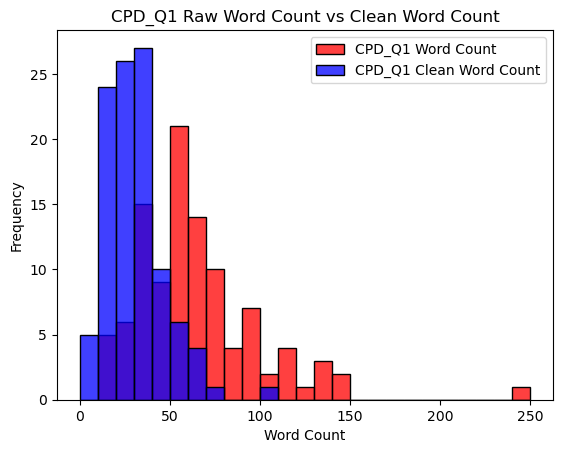

In [5]:
# Plotting word counts

custom_bins = list(range(0, 251, 10))

sns.histplot(data=data, x='CPD_Q1 Word Count', color='red', label='CPD_Q1 Word Count', bins=custom_bins)
sns.histplot(data=data, x='CPD_Q1 Clean Word Count', color='blue', label='CPD_Q1 Clean Word Count', bins=custom_bins)

plt.title("CPD_Q1 Raw Word Count vs Clean Word Count")

plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()

plt.show()

c:\Users\jergx\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jergx\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


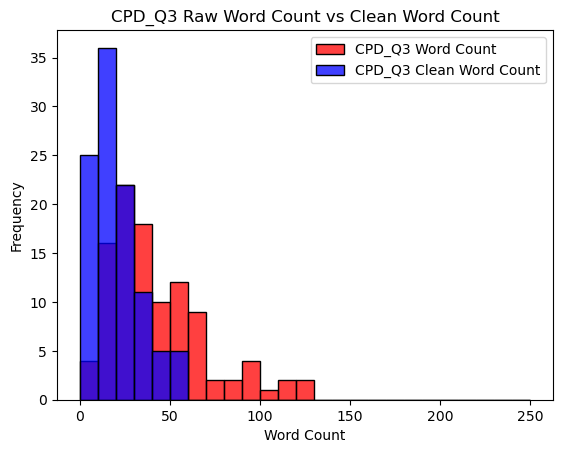

In [6]:
# Plotting word counts

custom_bins = list(range(0, 251, 10))

sns.histplot(data=data, x='CPD_Q3 Word Count', color='red', label='CPD_Q3 Word Count', bins=custom_bins)
sns.histplot(data=data, x='CPD_Q3 Clean Word Count', color='blue', label='CPD_Q3 Clean Word Count', bins=custom_bins)

plt.title("CPD_Q3 Raw Word Count vs Clean Word Count")
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()

plt.show()

In [7]:
data.sort_values(by=['CPD_Q3 Word Count'], ascending=True)['CPD_Q3'].head(15)

97          I’ve developed healthier exercising habits. 
59                 I found that the time was beneficial.
35                I felt much relief from school stress.
67         They helped me destress from school and life.
106      It gave me a small break to think about myself.
51     It makes me feel healthier and like a more-rou...
22     It helped me relax and get away from school an...
107    It was nice, but I don’t think it really affec...
79     It made me happier when I returned to continue...
93     It affected me positively and influenced me to...
42     It has allowed me more time to relax so I feel...
100    It allowed me to feel good about myself and be...
45     The time I spent helped me relax and concentra...
65     It helped clear my mind and maintain balance i...
91     I was able to focus on myself for a certain am...
Name: CPD_Q3, dtype: object

In [8]:
data.sort_values(by=['CPD_Q3 Clean Word Count'], ascending=True)['CPD_Q3 Clean'].head(15)

59                               [found, time, benefici]
67                        [help, destress, school, life]
106                          [gave, small, break, think]
100                      [allow, feel, good, compassion]
97                  [develop, healthier, exercis, habit]
107                [nice, think, realli, affect, overal]
35                  [felt, much, relief, school, stress]
51          [make, feel, healthier, like, round, person]
45           [time, spent, help, relax, concentr, studi]
42                [allow, time, relax, feel, le, stress]
79         [made, happier, return, continu, studi, work]
22                [help, relax, get, away, school, work]
91              [abl, focu, certain, amount, time, nice]
36     [gave, excus, someth, want, without, feel, gui...
63     [allow, focu, thing, neglect, lot, physic, hea...
Name: CPD_Q3 Clean, dtype: object

## Modelling/Tuning (Mostly done with CPD_Q1)

In [9]:
data.head()
modelling_data = data[['CPD_Q1 Clean', 'CPD_Q3 Clean']]
modelling_data.iloc[:,0]

0      [class, time, devot, health, well, self, care,...
1      [class, time, devot, health, well, self, care,...
2      [class, time, remind, import, self, care, also...
3      [class, time, devot, health, well, self, care,...
4      [learnt, listen, peopl, without, interrupt, le...
                             ...                        
102    [past, three, quarter, class, time, devot, hea...
103    [wonder, chang, pace, littl, time, especi, dem...
104    [mentor, team, discuss, team, professor, help,...
106    [person, think, nice, break, could, use, focu,...
107    [activ, dislik, content, relat, health, well, ...
Name: CPD_Q1 Clean, Length: 104, dtype: object

In [10]:
# Create Corpus
Q1_texts = modelling_data.iloc[:, 0]

# Create Dictionary
id2word = corpora.Dictionary(Q1_texts)


# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in Q1_texts]

# View
print(corpus[:1][0][:30])

[(0, 2), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 2), (28, 1), (29, 1)]


In [11]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [12]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.034*"help" + 0.034*"time" + 0.023*"class" + 0.019*"health" + '
  '0.016*"discuss" + 0.015*"u" + 0.015*"remind" + 0.013*"talk" + 0.013*"also" '
  '+ 0.012*"take"'),
 (1,
  '0.064*"time" + 0.037*"class" + 0.034*"care" + 0.027*"take" + 0.025*"well" + '
  '0.024*"health" + 0.020*"self" + 0.018*"help" + 0.015*"mental" + '
  '0.015*"import"'),
 (2,
  '0.030*"time" + 0.024*"think" + 0.023*"team" + 0.023*"help" + 0.022*"feel" + '
  '0.020*"discuss" + 0.020*"mentor" + 0.020*"allow" + 0.019*"well" + '
  '0.017*"school"'),
 (3,
  '0.037*"time" + 0.028*"health" + 0.022*"well" + 0.019*"care" + '
  '0.018*"stress" + 0.018*"class" + 0.016*"school" + 0.015*"work" + '
  '0.014*"mental" + 0.014*"devot"'),
 (4,
  '0.030*"school" + 0.018*"lot" + 0.018*"differ" + 0.018*"mentor" + '
  '0.012*"care" + 0.012*"self" + 0.012*"someth" + 0.012*"awar" + 0.012*"day" + '
  '0.012*"activ"'),
 (5,
  '0.028*"time" + 0.022*"also" + 0.022*"realli" + 0.021*"care" + '
  '0.018*"person" + 0.018*"help" + 0.018*"cla

In [13]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=Q1_texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.4083474458202578


In [14]:
# Supporting function
def compute_coherence_values(corpus, dictionary, k, a, b, texts):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [15]:
# Set up for modelling

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

In [21]:
# DO NOT RUN THIS CELL UNLESS YOU'RE TUNING LDA MODEL FOR <1 HOUR
# Can take a long time to run
"""
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b, texts=Q1_texts)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('./lda_tuning_results.csv', index=False)
    pbar.close()
"""

"\nif 1 == 1:\n    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))\n    \n    # iterate through validation corpuses\n    for i in range(len(corpus_sets)):\n        # iterate through number of topics\n        for k in topics_range:\n            # iterate through alpha values\n            for a in alpha:\n                # iterare through beta values\n                for b in beta:\n                    # get the coherence score for the given parameters\n                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, \n                                                  k=k, a=a, b=b, texts=Q1_texts)\n                    # Save the model results\n                    model_results['Validation_Set'].append(corpus_title[i])\n                    model_results['Topics'].append(k)\n                    model_results['Alpha'].append(a)\n                    model_results['Beta'].append(b)\n                    model_results['Coherence'].

In [22]:
# This was done separately since there was an error in the code above
# WILL NOT WORK SINCE MODEL_RESULTS IS UNDEFINED

#pd.DataFrame(model_results).to_csv('./lda_tuning_results.csv', index=False)

In [24]:
# Computing coherenence values takes ~11 seconds (Locally for James)
# Computing coherence value with optimal parameters from tuning
cv = compute_coherence_values(corpus=corpus_sets[1], dictionary=id2word, k=8, a=0.61, b=0.91, texts=Q1_texts)
print(cv)

0.6837747574533245


In [19]:
#Try Q3_texts using the same parameters 
# MOST OF MODELLING SET UP WAS USED WITH Q1_TEXTS, NEED TO SET UP FOR Q3_TEXTS FIRST!!!
cv = compute_coherence_values(corpus=corpus_sets[1], dictionary=id2word, k=8, a=0.61, b=0.91, texts=Q3_texts)
print(cv)

NameError: name 'Q3_texts' is not defined

In [27]:
# Below results were obtained on February 1, 2024, at ~2:05 AM
# Note: Alpha and Beta columns are STRING values
results = pd.read_csv("lda_tuning_results.csv")
results.sort_values(by=['Coherence'], ascending=False).head()

,Validation_Set,Topics,Alpha,Beta,Coherence
463,100% Corpus,8,0.61,0.9099999999999999,0.683775
493,100% Corpus,9,0.61,0.9099999999999999,0.677629
133,75% Corpus,6,0.61,0.9099999999999999,0.669763
268,75% Corpus,10,asymmetric,0.9099999999999999,0.644418
238,75% Corpus,9,asymmetric,0.9099999999999999,0.624758


After tuning the LDA parameters for ~53 minutes with 540 parameter variations, we found that our maximum Coherence score was about 0.683 given the following optimal parameters:

Validation_Set - 100% Corpus <br/>
Topics - 8 <br/>
Alpha - 0.61 <br/>
Beta - 0.91 <br/>

## Investigating Results

Text(0.5, 1.0, 'Distribution of coherence scores')

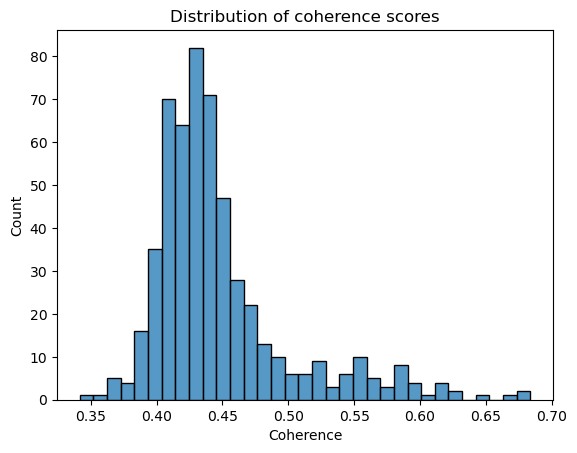

In [58]:
sns.histplot(data=results, x="Coherence")
plt.title("Distribution of coherence scores")

Text(0, 0.5, 'Coherence Score')

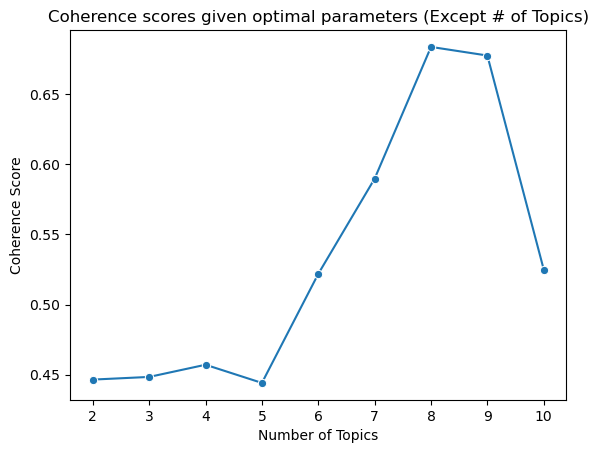

In [71]:
coherences_with_optimal_vs_a_b = results[(results["Alpha"] == "0.61") & (results["Validation_Set"] == "100% Corpus") & (results["Beta"].str.contains("0.909"))]


sns.lineplot(data=coherences_with_optimal_vs_a_b, x='Topics', y='Coherence', marker='o')

plt.title("Coherence scores given optimal parameters (Except # of Topics)")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")

## Final Model

In [102]:
final_lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.61,
                                           eta=0.91)

final_lda_model.print_topics()
#coherence_model_lda = CoherenceModel(model=final_lda_model, texts=Q1_texts, dictionary=id2word, coherence='c_v')
#print(coherence_model_lda.get_coherence())
#doc_lda = final_lda_model[corpus] # I don't know what this is / it's never used                                   

[(0,
  '0.004*"discuss" + 0.003*"help" + 0.003*"open" + 0.003*"util" + 0.003*"wednesday" + 0.003*"awar" + 0.003*"group" + 0.003*"often" + 0.003*"new" + 0.003*"convers"'),
 (1,
  '0.051*"time" + 0.027*"class" + 0.025*"care" + 0.024*"health" + 0.024*"well" + 0.017*"self" + 0.017*"take" + 0.013*"help" + 0.013*"mental" + 0.011*"devot"'),
 (2,
  '0.018*"time" + 0.016*"help" + 0.015*"mentor" + 0.015*"team" + 0.014*"think" + 0.014*"discuss" + 0.014*"school" + 0.013*"feel" + 0.012*"well" + 0.012*"class"'),
 (3,
  '0.004*"week" + 0.003*"sometim" + 0.003*"togeth" + 0.003*"wip" + 0.003*"nice" + 0.003*"everi" + 0.003*"lot" + 0.003*"high" + 0.003*"extra" + 0.003*"thought"'),
 (4,
  '0.004*"would" + 0.004*"learnt" + 0.003*"give" + 0.003*"tri" + 0.003*"without" + 0.003*"listen" + 0.003*"like" + 0.003*"put" + 0.003*"relat" + 0.003*"interrupt"'),
 (5,
  '0.005*"also" + 0.004*"professor" + 0.004*"made" + 0.004*"awar" + 0.003*"appreci" + 0.003*"belong" + 0.003*"care" + 0.003*"abl" + 0.003*"definit" + 0.0

In [88]:
# STILL BROKEN

import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import os

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./ldavis_tuned_'+str(8))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if False:
    LDAvis_prepared = gensimvis.prepare(final_lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_tuned_'+ str(8) +'.html')

LDAvis_prepared

FileNotFoundError: [Errno 2] No such file or directory: './ldavis_tuned_8'

## Miscellaneous

In [38]:
'''
Potential stop words to include considering the context
of our project
'''

# stopwords.append('pharmacy')
# stopwords.append('pharmacist')
# stopwords.append('pharmacists')
# stopwords.append('health')
# stopwords.append('healthcare')
# stopwords.append('practitioner')
# stopwords.append('mental')
# stopwords.append('wellness')
# stopwords.append('self-care')
# stopwords.append('mentor')
# stopwords.append('WIP')
# stopwords.append('class')
# stopwords.append('school')
# stopwords.append('peers')
# stopwords.append('classmates')
# stopwords.append('quarter')
# stopwords.append('spring')
# stopwords.append('winter')
# stopwords.append('fall')

None

In [39]:
# Split Q1 and Q3 into different dfs
'''
data_Q1 = data[["CPD_Q1"]]
data_Q1 = data_Q1.astype(str)

data_Q3 = data[["CPD_Q3"]]
data_Q3 = data_Q3.astype(str)
'''

None